Module 3: Machine Learning Dataset Preparation
• Split data into training and testing sets (e.g., 80:20).
• Select features for model input based on correlation with habitability.
• Define target variable: Habitability class (Habitable/Non-Habitable) or habitability score.
• Create data pipelines with scaling, encoding, and feature selection.

In [1]:
import pandas as pd

df = pd.read_csv("exoplanets_processed.csv")
df.head()


,pl_name,pl_rade,pl_bmasse,pl_dens,pl_eqt,pl_orbper,st_teff,st_lum,st_met,st_spectype_A1 IV-V,...,st_spectype_M5.0+0.5-0.5,st_spectype_M5.5+/-0.5,st_spectype_M5V,st_spectype_M6 V,st_spectype_M6.5+/-0.5,st_spectype_M8.0 V,st_spectype_M9-L1,st_spectype_m3 V,habitability_score,stellar_compatibility
0,BD+20 594 b,-0.787976,-0.418696,0.259680,-0.786651,-0.033827,0.753433,0.497019,-0.716506,0,...,0,0,0,0,0,0,0,0,1,2
1,CFHTWIR-Oph 98 b,2.405074,3.645964,-0.093686,1.504634,0.569718,-2.369909,-3.414303,-0.275842,0,...,0,0,0,0,0,0,1,0,0,1
2,COCONUTS-2 b,0.963345,2.859125,-0.093686,-0.991296,30.143598,-1.385594,-1.849483,0.017933,0,...,0,0,0,0,0,0,0,0,1,2
3,CoRoT-1 b,1.693584,0.094676,-0.149223,1.683698,-0.033830,0.920204,0.340299,-1.450945,0,...,0,0,0,0,0,0,0,0,1,2
4,CoRoT-10 b,0.693757,0.996893,0.031543,-0.687983,-0.033829,0.127133,0.340299,1.290961,0,...,0,0,0,0,0,0,0,0,1,2


In [2]:
# Binary target: 1 = Habitable, 0 = Not Habitable
df["habitable"] = (df["habitability_score"] >= 2).astype(int)

df["habitable"].value_counts()


habitable
0    767
1    143
Name: count, dtype: int64

In [3]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=["number"])

# Compute correlation matrix
corr = numeric_df.corr()


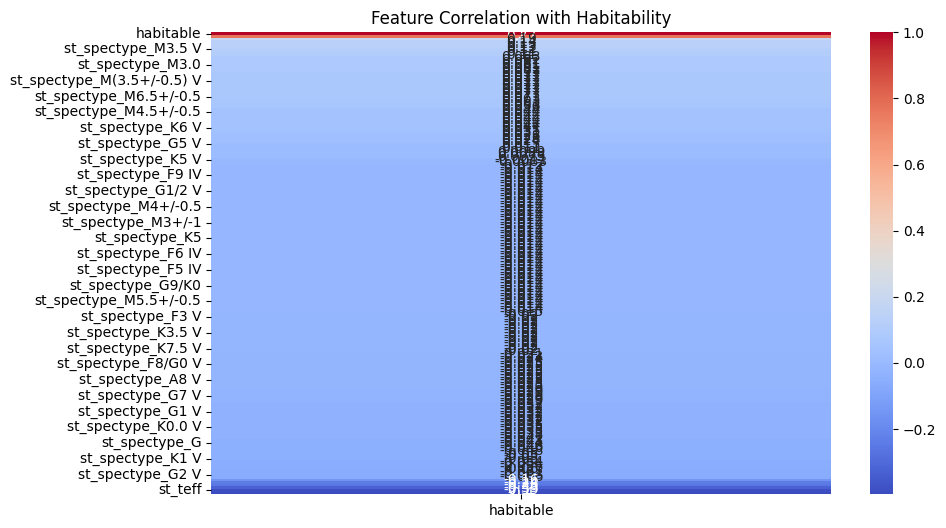

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))

sns.heatmap(
    corr[["habitable"]]
    .sort_values(by="habitable", ascending=False),
    annot=True,
    cmap="coolwarm"
)

plt.title("Feature Correlation with Habitability")
plt.show()


In [5]:
feature_cols = [
    "pl_rade", "pl_bmasse", "pl_dens",
    "pl_eqt", "pl_orbper",
    "st_teff", "st_lum", "st_met",
    "stellar_compatibility"
]

X = df[feature_cols]
y = df["habitable"]


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((728, 9), (182, 9))

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.978021978021978

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       153
           1       1.00      0.86      0.93        29

    accuracy                           0.98       182
   macro avg       0.99      0.93      0.96       182
weighted avg       0.98      0.98      0.98       182

ROC-AUC: 0.9984223574487266


<Axes: title={'center': 'Feature Importance'}>

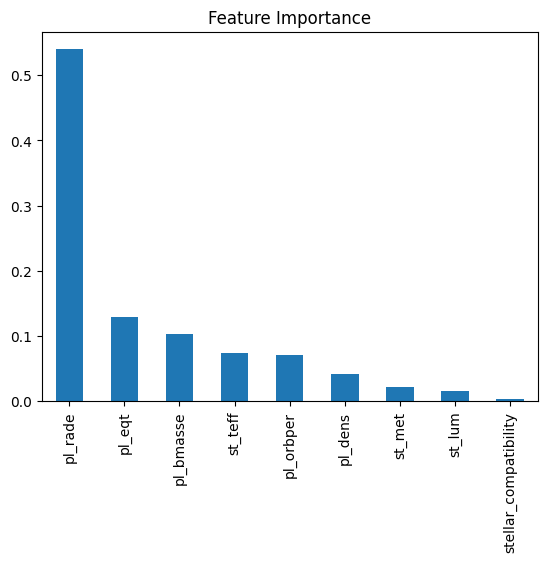

In [9]:
import pandas as pd

feature_importance = pd.Series(
    rf.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

feature_importance.plot(kind="bar", title="Feature Importance")


In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9120879120879121


In [11]:
from sklearn.svm import SVC

svm = SVC(probability=True)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Accuracy: 0.8626373626373627


In [12]:
df["habitability_probability"] = rf.predict_proba(X)[:, 1]

top_habitable = df.sort_values(
    by="habitability_probability",
    ascending=False
)[["pl_name", "habitability_probability"]].head(10)

top_habitable


,pl_name,habitability_probability
354,Kepler-249 b,1.000
556,TOI-1450 A b,1.000
721,TOI-5720 b,0.995
58,GJ 9827 c,0.995
467,LTT 3780 b,0.995
446,L 98-59 c,0.995
642,TOI-270 b,0.995
44,GJ 357 b,0.995
339,Kepler-186 c,0.995
338,Kepler-186 b,0.995


In [13]:
from xgboost import XGBClassifier


In [14]:
feature_cols = [
    "pl_rade", "pl_bmasse", "pl_dens",
    "pl_eqt", "pl_orbper",
    "st_teff", "st_lum", "st_met",
    "stellar_compatibility"
]

X = df[feature_cols]
y = df["habitable"]


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [16]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [17]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

import pandas as pd
import matplotlib.pyplot as plt


In [20]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)

    # Handle probability output safely
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        y_prob = None
        roc_auc = None

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc
    }

    return metrics, y_prob


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)
xgb.fit(X_train, y_train)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

svm = SVC(probability=True)   # IMPORTANT
svm.fit(X_train, y_train)


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [22]:
results = []
roc_data = {}

rf_metrics, rf_prob = evaluate_model(rf, X_test, y_test, "Random Forest")
xgb_metrics, xgb_prob = evaluate_model(xgb, X_test, y_test, "XGBoost")
lr_metrics, lr_prob = evaluate_model(lr, X_test, y_test, "Logistic Regression")
svm_metrics, svm_prob = evaluate_model(svm, X_test, y_test, "SVM")

results.extend([rf_metrics, xgb_metrics, lr_metrics, svm_metrics])

roc_data["Random Forest"] = rf_prob
roc_data["XGBoost"] = xgb_prob
roc_data["Logistic Regression"] = lr_prob
roc_data["SVM"] = svm_prob


In [23]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Random Forest,0.989011,1.000000,0.931034,0.964286,0.998873
1,XGBoost,0.983516,1.000000,0.896552,0.945455,0.999324
2,Logistic Regression,0.912088,0.882353,0.517241,0.652174,0.935317
3,SVM,0.862637,0.833333,0.172414,0.285714,0.876944


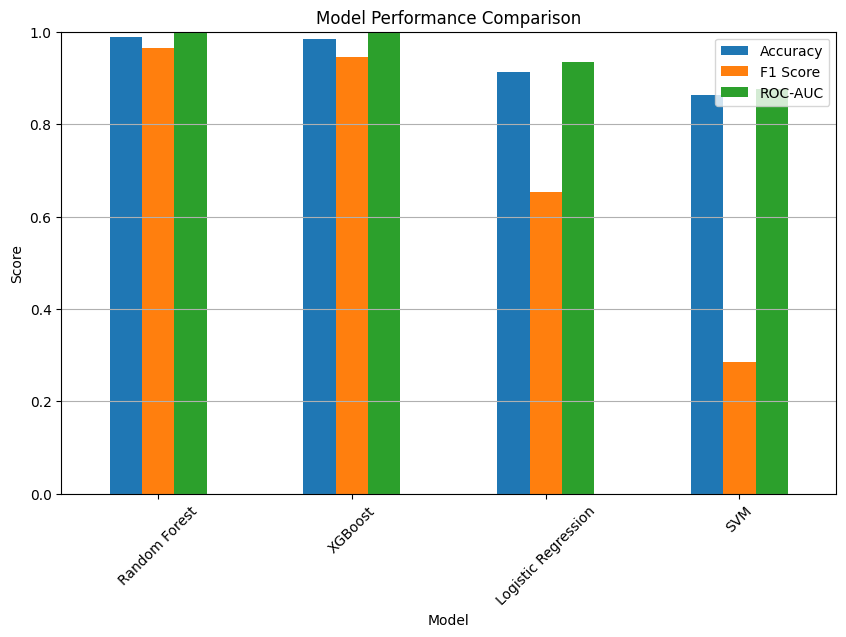

In [24]:
import matplotlib.pyplot as plt

metrics_to_plot = ["Accuracy", "F1 Score", "ROC-AUC"]

results_df.set_index("Model")[metrics_to_plot].plot(
    kind="bar",
    figsize=(10,6)
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()


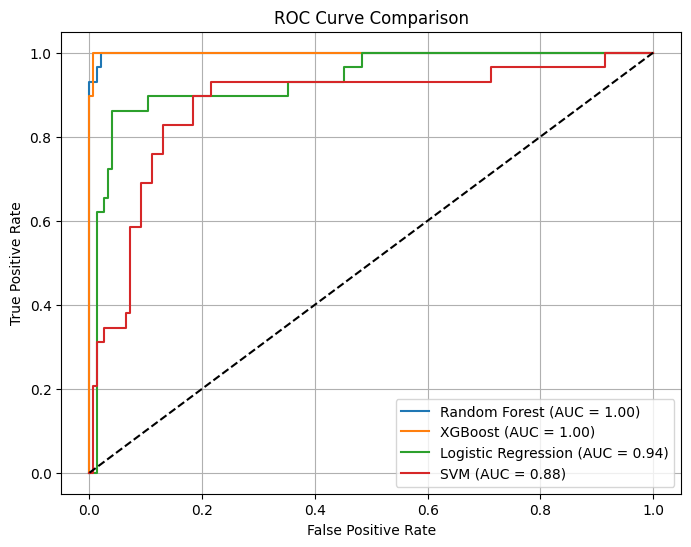

In [25]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for model_name, probs in roc_data.items():
    if probs is not None:
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()


In [26]:
df["habitability_probability"] = xgb.predict_proba(X)[:, 1]


In [27]:
df[["pl_name", "habitability_probability"]] \
    .sort_values(by="habitability_probability", ascending=False) \
    .head(10)


,pl_name,habitability_probability
368,Kepler-296 d,0.999705
328,Kepler-138 d,0.999351
342,Kepler-205 c,0.999351
356,Kepler-249 d,0.999208
597,TOI-198 b,0.999172
340,Kepler-186 d,0.999172
265,K2-3 d,0.999159
421,Kepler-62 f,0.999117
58,GJ 9827 c,0.999113
444,L 98-59 c,0.999113
